# Preprocessing
Process the text on the Text column, and create a new column processed_text to store the processed text

In [1]:
from deployment.preprocess_fn import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wyiti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# read in raw data
df_path = 'data/raw/reviews.csv'
df = pd.read_csv(df_path, parse_dates = ['Time'])
df.head()

,Sentiment,Time,Text
0,positive,2021-06-18,This is a very healthy dog food. Good for thei...
1,positive,2021-07-07,I've been very pleased with the Natural Balanc...
2,positive,2021-06-18,"Before I was educated about feline nutrition, ..."
3,positive,2021-07-07,"My holistic vet recommended this, along with a..."
4,positive,2021-01-07,I bought this coffee because its much cheaper ...


In [3]:
%%time
# preprocess the text
df = preprocess(df, label_col_name = 'Sentiment')

CPU times: total: 8.86 s
Wall time: 18.6 s


In [4]:
df.head()

,Sentiment,Time,Text,processed_text
0,1,2021-06-18,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...
1,1,2021-07-07,I've been very pleased with the Natural Balanc...,pleased natural balance dog food dog issue dog...
2,1,2021-06-18,"Before I was educated about feline nutrition, ...",educate feline nutrition allow cat become addi...
3,1,2021-07-07,"My holistic vet recommended this, along with a...",holistic vet recommend along brand try cat pre...
4,1,2021-01-07,I bought this coffee because its much cheaper ...,buy coffee much cheaper ganocafe organic reish...


In [5]:
# show the preprocessed text
for i in range(3):
    print(f'Row {i}')
    print('-----')
    print(df.iloc[i]['Text'])
    print()
    print(df.iloc[i]['processed_text'])
    print()

Row 0
-----
This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

healthy dog food good digestion also good small puppy dog eats require amount every feeding

Row 1
-----
I've been very pleased with the Natural Balance dog food. Our dogs have had issues with other dog foods in the past and I had someone recommend Natural Balance grain free since it is possible they were allergic to grains. Since switching I haven't had any issues. It is also helpful that have have different kibble size for larger/smaller sized dogs.

pleased natural balance dog food dog issue dog food past someone recommend natural balance grain free since possible allergic grain since switch issue also helpful different kibble size larger smaller sized dog

Row 2
-----
Before I was educated about feline nutrition, I allowed my cats to become addicted to dry cat food. I always offered both canned and dry, but wish I would have fed them

# EDA

In [6]:
eda_df = df.copy()
eda_df['Time'] = pd.to_datetime(eda_df['Time'])
eda_df['year'] = eda_df.Time.dt.year
eda_df['month'] = eda_df.Time.dt.month.map("{:02}".format)
eda_df['day'] = eda_df.Time.dt.day.map("{:02}".format)
eda_df['yearmonth'] = eda_df.year.astype('str') + '-' + eda_df.month.astype('str')
eda_df['num_of_words'] = eda_df.processed_text.apply(lambda x:len(x.split()))
eda_df.head()

,Sentiment,Time,Text,processed_text,year,month,day,yearmonth,num_of_words
0,1,2021-06-18,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...,2021,06,18,2021-06,15
1,1,2021-07-07,I've been very pleased with the Natural Balanc...,pleased natural balance dog food dog issue dog...,2021,07,07,2021-07,32
2,1,2021-06-18,"Before I was educated about feline nutrition, ...",educate feline nutrition allow cat become addi...,2021,06,18,2021-06,75
3,1,2021-07-07,"My holistic vet recommended this, along with a...",holistic vet recommend along brand try cat pre...,2021,07,07,2021-07,41
4,1,2021-01-07,I bought this coffee because its much cheaper ...,buy coffee much cheaper ganocafe organic reish...,2021,01,07,2021-01,29


## Trends in Number of Reviews

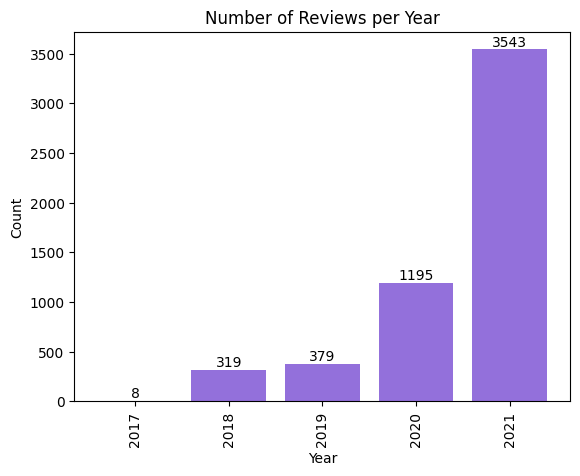

In [7]:
ax = eda_df.groupby('year').size().plot.bar(color = 'mediumpurple', width = 0.8)
ax.bar_label(ax.containers[0])
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

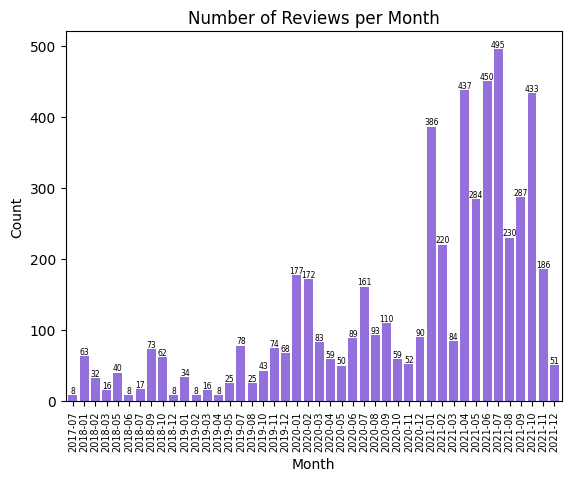

In [8]:
ax = eda_df.groupby('yearmonth').size().plot.bar(color = 'mediumpurple', width = 0.8)
ax.bar_label(ax.containers[0], fontsize = 5.5)
plt.title('Number of Reviews per Month')
plt.xlabel('Month')
plt.xticks(fontsize = 7)
plt.ylabel('Count')
plt.show()

## Positive vs Negative

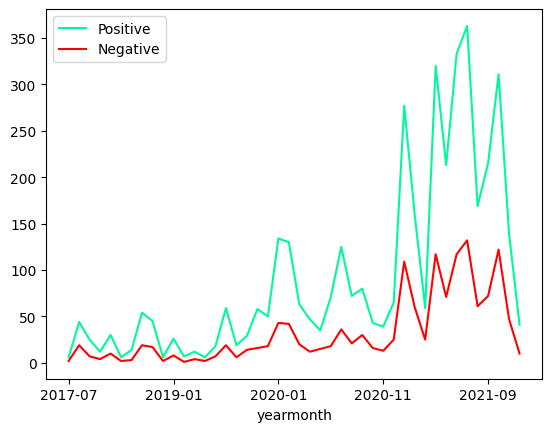

In [9]:
positive_df = eda_df.loc[df.Sentiment == 1]
positive_size_df = positive_df.groupby('yearmonth').size()

negative_df = eda_df.loc[df.Sentiment == 0]
negative_size_df = negative_df.groupby('yearmonth').size()

ax = positive_size_df.plot.line(color = 'mediumspringgreen')
negative_size_df.plot.line(ax = ax, color = 'red')
ax.legend(["Positive", "Negative"])
plt.show()

## Trends in Average Sentiments

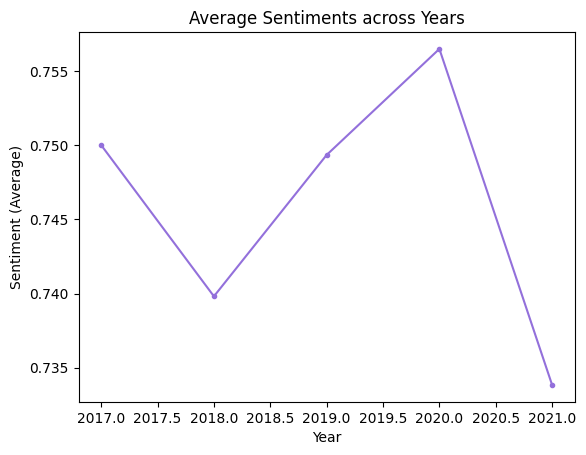

In [10]:
eda_df.groupby('year')['Sentiment'].mean().plot.line(style = '.-', color = 'mediumpurple')
plt.title('Average Sentiments across Years')
plt.xlabel('Year')
plt.ylabel('Sentiment (Average)')
plt.show()

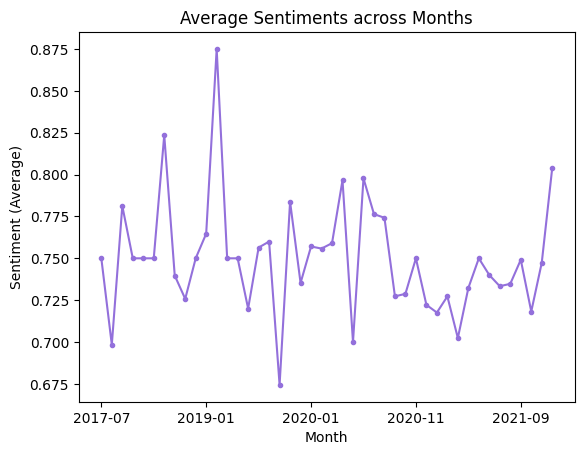

In [11]:
eda_df.groupby('yearmonth')['Sentiment'].mean().plot.line(style = '.-', color = 'mediumpurple')
plt.title('Average Sentiments across Months')
plt.xlabel('Month')
plt.ylabel('Sentiment (Average)')
plt.show()

# Sentiment Analysis

For Machine Learning models, we make use of the preprocessing done above for feature engineering with TF-IDF Vectorizer.

In [12]:
# train test split
x_train, x_test, y_train, y_test = split_train_test(df['processed_text'], df['Sentiment'])

In [13]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4355,) (4355,)
(1089,) (1089,)


## Training - XGBoost

When xgb_instantiate_tfidf_vectorizer() is called, it will intialise a TF-IDF Vectorizer, it will return a fitted TF-IDF Vectorizer.<br>
When xgb_instantiate_xgb_model() is called, it will intialise a XGBoost model, and return a fitted XGBoost model with the train data.

In [14]:
from sentiment_analysis.ML.xgboost_model import xgb_instantiate_tfidf_vectorizer, xgb_instantiate_xgb_model, xgb_get_classification_report, xgb_print_classifcation_rerport, xgb_get_confusion_matrix

In [15]:
# initialise tfidf vectorizer and fit train data into it
xgboost_vectorizer = xgb_instantiate_tfidf_vectorizer(x_train)
train_vectors = xgboost_vectorizer.transform(x_train)
test_vectors = xgboost_vectorizer.transform(x_test)

In [16]:
print(train_vectors.shape)
print(test_vectors.shape)

(4355, 9186)
(1089, 9186)


In [17]:
# initialise xgb and fit training features and labels into it
xgb_model = xgb_instantiate_xgb_model(train_vectors, y_train)

## Training - SVM

When svm_instantiate_tfidf_vectorizer() is called, it will intialise a TF-IDF Vectorizer, it will return a fitted TF-IDF Vectorizer.<br>
When svm_instantiate_svm_model() is called, it will intialise a SVM model, and return a fitted SVM model with the train data.

In [18]:
from sentiment_analysis.ML.svm_model import svm_instantiate_tfidf_vectorizer, svm_instantiate_svm_model, svm_get_classification_report, svm_print_classifcation_rerport, svm_get_confusion_matrix

In [19]:
# initialise tfidf vectorizer and fit train data into it
svm_vectorizer = svm_instantiate_tfidf_vectorizer(x_train)
train_vectors = svm_vectorizer.transform(x_train)
test_vectors = svm_vectorizer.transform(x_test)

In [20]:
print(train_vectors.shape)
print(test_vectors.shape)

(4355, 9186)
(1089, 9186)


In [21]:
# initialise svm and fit training features and labels into it
svm_model = svm_instantiate_svm_model(train_vectors, y_train)

## Training - distilBERT
To be run with GPU backend using AWS

In [22]:
# from sentiment_analysis.Deep_Learning.bert import *
import sentiment_analysis.Deep_Learning.distilbert_train_modules as dbtm
import sentiment_analysis.Deep_Learning.distilbert as db

C:\Users\wyiti\anaconda3\envs\dsa4263\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Import configuration
config = dbtm.CONFIG
model, training_args, training_tokenizer, data_collator = dbtm.build_config(config=config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

In [24]:
filename = './data/raw/reviews.csv'
preprocessed_data = dbtm.preprocess_data_for_train(filename=filename)
tokenized_dataset, full_dataset, train_dataset, val_dataset, test_dataset = dbtm.prepare_training_data(preprocessed_data, config=config, training_tokenizer=training_tokenizer)

In [25]:
bert_x_test = test_dataset['text']

In [ ]:
dbtm.hasGPU()

In [ ]:
# Training -> DO NOT RUN THIS CELL! (it may write large BERT models into the repository)
import time

start_time = time.time()
dbtm.train(model=model, training_args=training_args, tokenized_dataset=tokenized_dataset, tokenizer=training_tokenizer,\
           data_collator=data_collator, compute_metrics=dbtm.compute_metrics)
## This run will save different model checkpoints (folders) into the specified directory in config
## The model behind scoring API is the last checkpoint, which has highest validation accuracy
end_time = time.time()
print(f'Training time: {end_time - start_time}')

In [ ]:
bertfolder = config['output_dir']
try: # load local directory for model saved from training
    bert_model, bert_tokenizer = dbtm.load_model_dynamic(f'./{bertfolder}/checkpoint-2050')
# OR
except: # load the same model that's published in HuggingFace
    bert_model, bert_tokenizer = dbtm.load_model_dynamic("DreamyBeaver/distilBERT-SA-pietonium")

In [ ]:
# new_test_filename = 'reviews_test.csv' -> used later when prof gives test data
# new_out_filename = "reviews_test_predictions_pietonium.csv"

# for now just use the existing data
new_test_filename = './data/raw/reviews.csv' # for testing
new_out_filename = 'alldata_pred.csv'
try:
    predicted_df = db.scoring_file_to_csv(filename=new_test_filename, model=bert_model, tokenizer=bert_tokenizer, output_filename=new_out_filename)
except:
    print('Scoring unsuccessful, please check the input file or scoring function in distilbert.py')

## Evaluation
Evaluate the predictions of all three models - SVM, XGBoost and BERT

In [26]:
from deployment.evaluate import evaluate_with_models
from deployment.comparison import *

In [27]:
# to be deleted, just to test my evaluate.py
bert_model, bert_tokenizer = db.load_distilbert_model()

In [28]:
target_models = [("xgboost", xgb_model), ("svm", svm_model), ("bert", (bert_model, bert_tokenizer))]

In [29]:
evaluation_output = evaluate_with_models(test_vectors, bert_x_test, y_test, target_models)
evaluation_output

Evaluating xgboost ...
Evaluating svm ...
Evaluating bert ...


{'xgboost': {'prediction': array([1, 1, 1, ..., 1, 0, 1]),
  'prediction_prob': array([[0.04895574, 0.95104426],
         [0.03126103, 0.968739  ],
         [0.01237935, 0.98762065],
         ...,
         [0.00713617, 0.99286383],
         [0.62125325, 0.37874678],
         [0.39781797, 0.60218203]], dtype=float32),
  'metrics': {'cm': array([[172, 113],
          [ 46, 758]], dtype=int64),
   'accuracy': 0.8539944903581267,
   'precision': 0.870264064293915,
   'recall': 0.9427860696517413}},
 'svm': {'prediction': array([1, 1, 1, ..., 1, 0, 1], dtype=int64),
  'prediction_prob': array([[1.80644658e-02, 9.81935534e-01],
         [1.78959760e-01, 8.21040240e-01],
         [6.64402167e-06, 9.99993356e-01],
         ...,
         [9.75085410e-08, 9.99999902e-01],
         [8.87607049e-01, 1.12392951e-01],
         [8.99387424e-02, 9.10061258e-01]]),
  'metrics': {'cm': array([[195,  90],
          [ 38, 766]], dtype=int64),
   'accuracy': 0.8824609733700642,
   'precision': 0.8948598130

## Comparison
Compare the results among the three models, and choose the best one based on a metric

xgboost: 0.8539944903581267
svm: 0.8824609733700642
bert: 0.9274563820018366
Best Model: BERT with accuracy = 0.9274563820018366


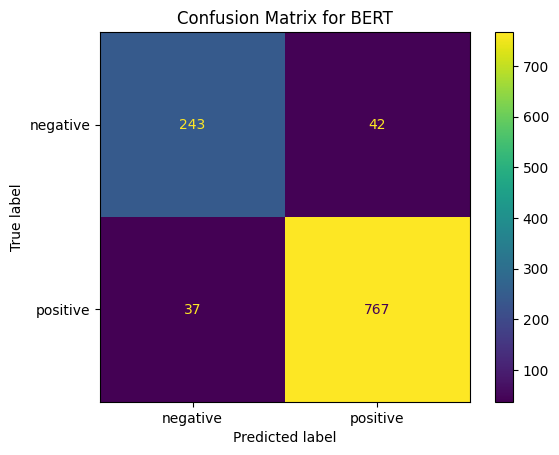

In [30]:
best_model_name, best_model_results = get_best_model(evaluation_output, metric = "accuracy")

## Conclusion - XGBoost vs SVM vs distilBERT: distilBERT
For the get_best_model function to compare the different models, we chose accuracy as the metric because:
1. Balanced evaluation<br>
Accuracy takes into account both positive and negative sentiment, providing a balanced evaluation of the model's performance across the entire dataset. Precision and recall, on the other hand, are more focused on one class at a time and may not give a complete picture of the model's performance. <br>

2. Business relevance<br>
In many real-world scenarios, accuracy is the most important metric for sentiment analysis. For example, if you are building a product that uses sentiment analysis to identify customer sentiment, the accuracy of the model will be directly related to the product's success.

Therefore, we chose distilBERT as our final model.

## Test on Unseen Dataset

In [ ]:
test_df_path = ""
test_df = pd.read_csv(test_df_path)

In [ ]:
model, tokenizer = db.load_distilbert_model()
predicted_df = scoring_file_thread_df(test_df, model, tokenizer)

In [ ]:
predicted_df.to_csv("reviews_test_predictions_pietonium.csv")

In [ ]:
predicted_df.head()

In [ ]:
# if there is actual label:
predicted_labels = predicted_df.predicted_sentiment
actual_labels = predicted_df.Sentiment
db.visualize_confusion_matrix(predicted_labels, actual_labels)

# Topic Classification

## Gensim LDA

In [32]:
from topic_modelling import lda_gensim_modularized as gensim_lda

In [33]:
# Read in cleaned reviews
df_path = 'data/curated/reviews/cleaned_reviews.csv'
clean_data = gensim_lda.read_data(df_path)

In [34]:
# obtain tfidf corpus
data = gensim_lda.combine_reviews_to_list(clean_data)
data_words, id2word, bow_corpus = gensim_lda.obtain_corpus(data)
corpus_tfidf = gensim_lda.get_tfidf_corpus(bow_corpus)

In [35]:
# run LDA baseline model
lda_base_model = gensim_lda.load_base_lda_model(data_words, id2word, corpus_tfidf)

Baseline Coherence Score:  0.3741965329013099


Num Topics = 2  has Coherence Value of 0.359
Num Topics = 3  has Coherence Value of 0.6139
Num Topics = 4  has Coherence Value of 0.4942
Num Topics = 5  has Coherence Value of 0.5442
Num Topics = 6  has Coherence Value of 0.5589
Num Topics = 7  has Coherence Value of 0.5161
Num Topics = 8  has Coherence Value of 0.56
Num Topics = 9  has Coherence Value of 0.574


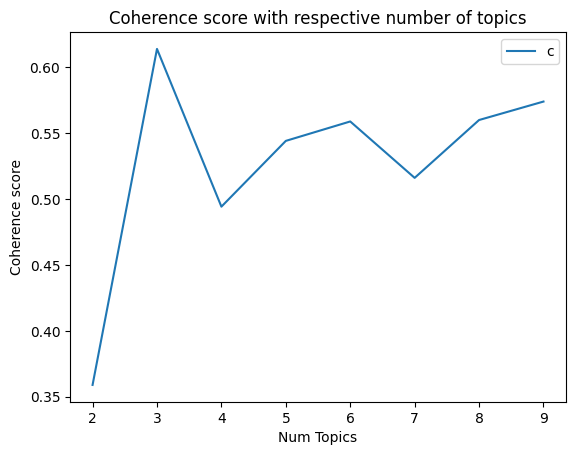

CPU times: total: 25.3 s
Wall time: 4min 13s


In [36]:
%%time
# Obtain optimal number of topics
final_num_topics, final_score, coherence_score_topic = gensim_lda.get_coherence_values_and_optimal_topic_num(corpus_tfidf,10, id2word, data_words)

In [37]:
# run final LDA model using optimal number of topics
lda_final_model = gensim_lda.load_final_lda_model(id2word, corpus_tfidf, final_num_topics)

# print 10 keywords of the topics
gensim_lda.unique_sets(lda_final_model)

Topic: 0 
Words: 0.005*"coffee" + 0.004*"tea" + 0.004*"cup" + 0.003*"love" + 0.003*"price" + 0.003*"buy" + 0.003*"much" + 0.003*"chocolate" + 0.003*"try" + 0.003*"really"
Topic: 1 
Words: 0.003*"snack" + 0.003*"love" + 0.003*"bar" + 0.003*"price" + 0.003*"chip" + 0.003*"find" + 0.003*"buy" + 0.003*"try" + 0.003*"eat" + 0.003*"would"
Topic: 2 
Words: 0.004*"tea" + 0.004*"dog" + 0.003*"treat" + 0.003*"food" + 0.002*"love" + 0.002*"buy" + 0.002*"coffee" + 0.002*"cat" + 0.002*"eat" + 0.002*"china"
Topic 0: {'really', 'much', 'chocolate', 'cup'}
Topic 1: {'find', 'snack', 'bar', 'would', 'chip'}
Topic 2: {'food', 'cat', 'dog', 'treat', 'china'}


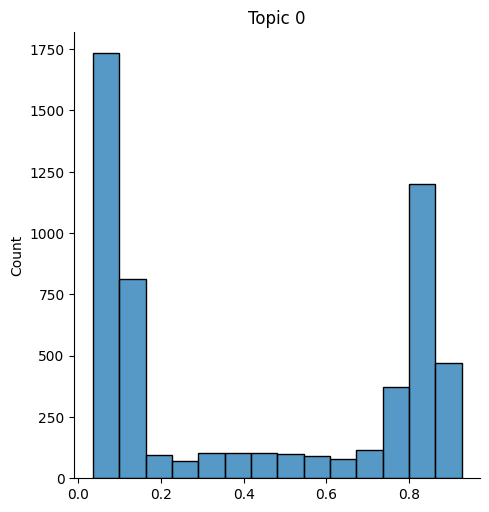

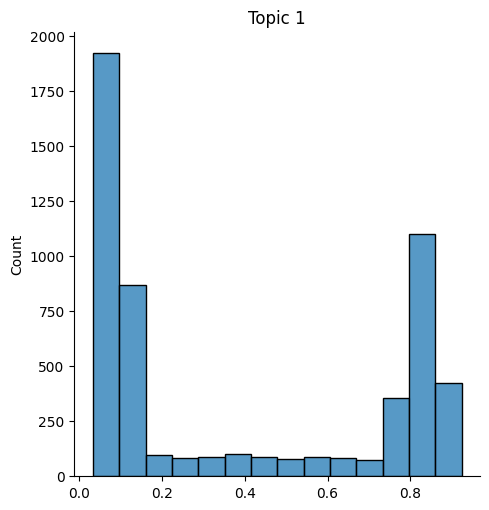

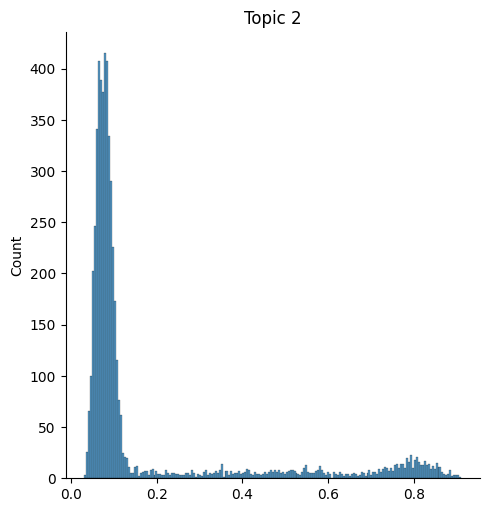

In [38]:
topic_per_contri_per_review = gensim_lda.get_all_topic_distribution(lda_final_model, corpus_tfidf)

In [39]:
# Obtain the dominant topic for each review and save it to csv
topic_review_df = gensim_lda.dominant_topic_per_review(lda_final_model, corpus_tfidf, data)

# topic distribution 
gensim_lda.topic_distri_across_review(topic_review_df)

0    2460
1    2231
2     753
Name: Dominant_Topic, dtype: int64

## Scikit-Learn LDA

In [40]:
import topic_modelling.lda_sklearn as sklearn_lda

### Get ideal no. of topics

In [41]:
%%time
df = pd.read_csv('data/curated/reviews/cleaned_reviews.csv')
vectorized_text = sklearn_lda.vectorize(df)
n_topic, cv_score = sklearn_lda.get_n_topic(df,vectorized_text)
print(f'Number of Topics: {n_topic}')
print(f'Coherence Score: {cv_score}')

Number of Topics: 3
Coherence Score: 0.49597964090744556
CPU times: total: 52 s
Wall time: 5min 59s


### Top 10 words in each topic

Topic 0: 
coffee price product buy amazon store great love food dog
Topic 1: 
great good taste chip make product use free easy salt
Topic 2: 
taste tea like flavor drink water good use sugar try


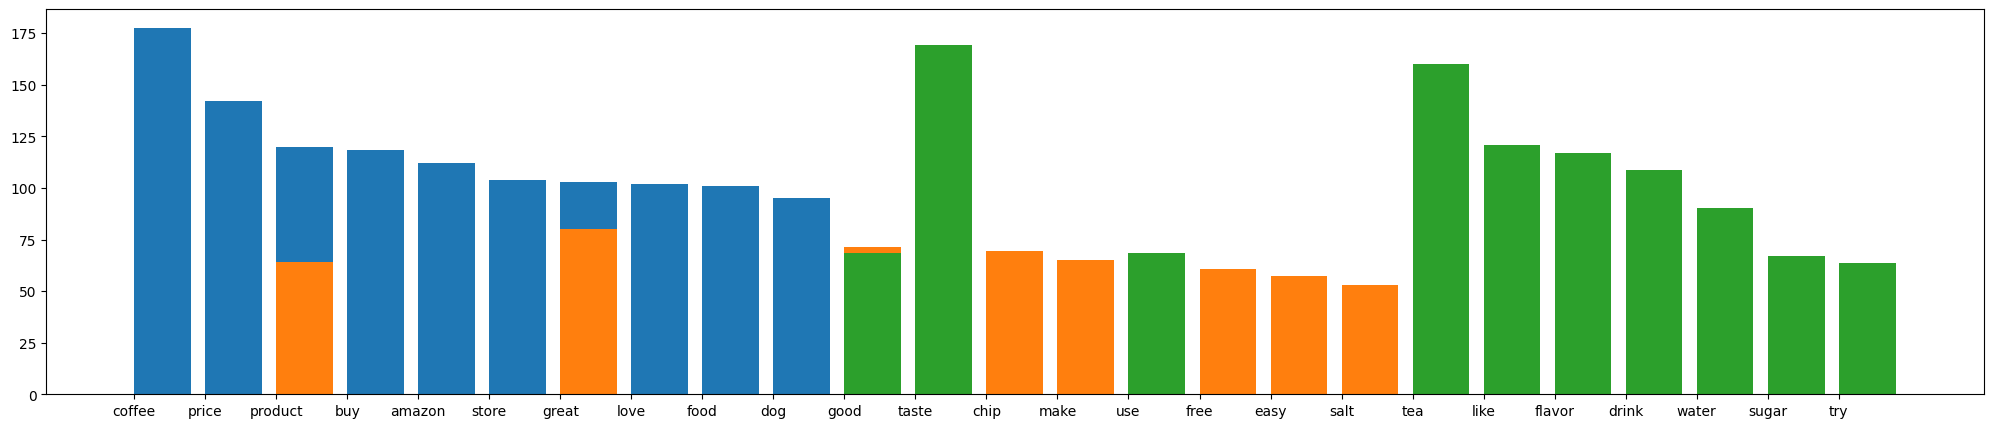

In [42]:
lda_model_sklearn = sklearn_lda.build_lda(n_topic,vectorized_text)
sklearn_lda.get_topics(lda_model_sklearn,df)

### Topic breakdown

In [43]:
sklearn_lda.get_dominant_topics(lda_model_sklearn,df) #Fairly even

0    2487
1    1407
2    1550
Name: dominant_topic, dtype: int64

### Breakdown of the probability of each doc belonging to each topic

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.77,0.12,0.11,0
Doc1,0.82,0.09,0.09,0
Doc2,0.85,0.08,0.08,0
Doc3,0.47,0.19,0.34,0
Doc4,0.84,0.08,0.08,0
...,...,...,...,...
Doc5439,0.63,0.18,0.19,0
Doc5440,0.67,0.10,0.23,0
Doc5441,0.33,0.11,0.57,2
Doc5442,0.81,0.09,0.10,0


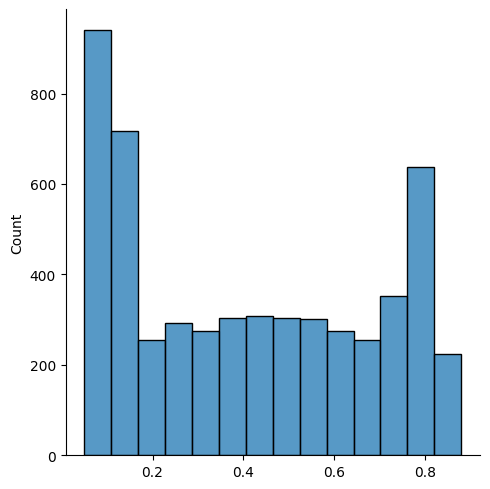

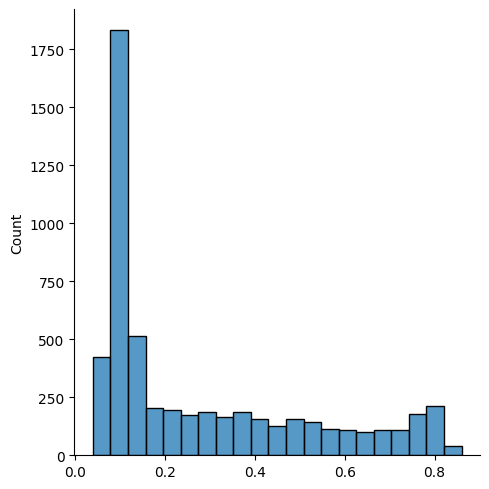

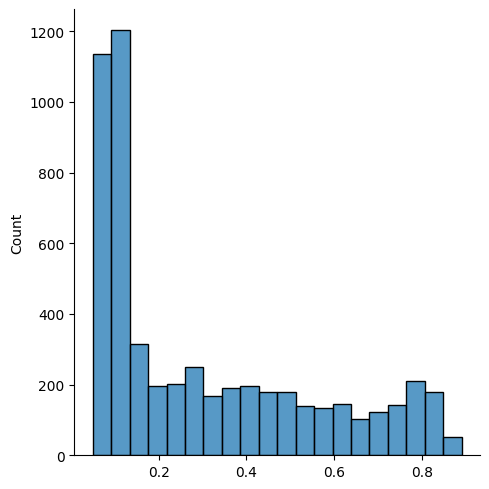

In [44]:
sklearn_lda.get_topic_weights(lda_model_sklearn,df)

## Conclusion - Gensim vs sklearn: Gensim 
Based on our own judgements, the distribution of the words for each topic output by Gensim is easier to come out with a topic name. Furthermore, the coherance score of Gensim LDA is <b>0.6139</b>, which is higher than sklearn LDA's coherance score of <b>0.4959</b>.

Topic 0: {'really', 'much', 'chocolate', 'cup'} - Dessert <br>
Topic 1: {'find', 'snack', 'bar', 'would', 'chip'} - Snacks and Chips <br>
Topic 2: {'food', 'cat', 'dog', 'treat', 'china'} - Pet Related

# Topic Classification

In [45]:
from topic_modelling import topic_classification_modularized as tm

In [46]:
train, test = tm.split_test_train(topic_review_df)
y_train, y_test = tm.y_label(train, test)

In [47]:
# Obtain train and test corpus respectively using LDA dictionary aka id2words 
x_train_corpus = tm.preprocess_test_train(train, id2word)
x_test_corpus = tm.preprocess_test_train(test, id2word)

In [48]:
# Convert corpus to vectors to feed into sklearn
train_vecs = tm.create_vectors(x_train_corpus, train, lda_final_model, final_num_topics)
test_vecs = tm.create_vectors(x_test_corpus, test, lda_final_model, final_num_topics)

In [49]:
# Convert vector to scaled numpy array
x_train_scale, y_train = tm.convert_vector_to_scaled_array(train_vecs, y_train)
x_test_scale, y_test = tm.convert_vector_to_scaled_array(test_vecs, y_test)

In [52]:
# Baseline svc
base_svc = tm.baseline_svc(x_train_scale, y_train)

classification_report_base, confusion_matrix_base = tm.predict_and_evaluate_model(base_svc, x_test_scale, y_test)
print(classification_report_base)
print(confusion_matrix_base)

              precision    recall  f1-score      support
0              0.946581  0.911523  0.928721   486.000000
1              0.924107  0.926174  0.925140   447.000000
2              0.780347  0.865385  0.820669   156.000000
accuracy       0.910927  0.910927  0.910927     0.910927
macro avg      0.883678  0.901027  0.891510  1089.000000
weighted avg   0.913543  0.910927  0.911772  1089.000000
     0    1    2
0  443   19   24
1   19  414   14
2    6   15  135


In [53]:
tm.tune_hyperparameter(x_train_scale, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.2s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.2s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.2s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.2s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.2s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................

[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ...................

In [54]:
# Final svc
svc_final = tm.final_svc(x_train_scale, y_train,  0.1,  0.01, 'sigmoid')

classification_report_final, confusion_matrix_final = tm.predict_and_evaluate_model(svc_final, x_test_scale, y_test)
print(classification_report_final)
print()
print(confusion_matrix_final)

              precision    recall  f1-score      support
0              0.973577  0.985597  0.979550   486.000000
1              0.977778  0.984340  0.981048   447.000000
2              0.986395  0.929487  0.957096   156.000000
accuracy       0.977043  0.977043  0.977043     0.977043
macro avg      0.979250  0.966475  0.972565  1089.000000
weighted avg   0.977138  0.977043  0.976948  1089.000000

     0    1    2
0  479    5    2
1    7  440    0
2    6    5  145
